In [46]:
# BERT stuff

"""
NOTE: Implementation inspired by Hugging Face's tutorial: 
https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
"""
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install transformers==3

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import re
import seaborn as sn
from sklearn.preprocessing import LabelBinarizer
from tqdm.notebook import tqdm

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/Colab

/content/drive/MyDrive/Colab


## Processing the data 


In [4]:
# import the dataset

# Path Kodjo
# path = '/home/anselme/Desktop/Etude/MVA_S1/DL/MVA_DL/Data Mining'

dataset = pd.read_excel('dataset.xlsx', skiprows=0)

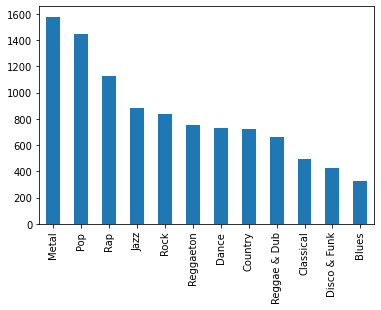

In [5]:
dataset['Class'].value_counts().plot(kind='bar')
plt.show()

In [9]:
# Dataset shuffle occurs here

from sklearn.utils import shuffle
dataset = shuffle(dataset)

dataset

,Name,Artist,Album,Release Date,Lyrics,Class
6475,Summer Days,Martin Garrix,Summer Days (feat. Macklemore & Patrick Stump ...,2019-07-12,[Intro: Patrick Stump]\nI got this feeling on ...,Dance
444,Slaves of Fear,Amon Amarth,Surtur Rising,2011-03-29,They speak of love and tolerance\nThey thrive ...,Metal
3140,Torch,Emmure,Look at Yourself,2017-03-03,[Intro]\nI did not pass the torch\nJust to be ...,Metal
361,Allah Tano,Alpha Blondy,Positive Energy,2015-05-18,[Alpha]\nLa ilaha i la la Mohamadou Rassoulila...,Reggae & Dub
2846,Laugh Now Cry Later,Drake,Laugh Now Cry Later (feat. Lil Durk),2020-08-14,"[Intro: Drake]\nWoah, woah\nYeah\n\n[Chorus: D...",Rap
...,...,...,...,...,...,...
3284,The Gentle Art of Making Enemies,Faith No More,"King for a Day, Fool for a Lifetime (2016 Rema...",1995,[Verse 1]\nThe words are so familiar\nAll the ...,Metal
1650,KNOW ME,BRONSON,KNOW ME (Cassian Remix),2020-09-29,"[Verse 1]\nKarma used to move so fast, move so...",Dance
486,Amo Soltanto Te,Andrea Bocelli,Sì Forever (The Diamond Edition),2019-11-08,[Strofa 1: Andrea Bocelli]\nÈ troppo tempo che...,Classical
5552,Agnus Dei,Katherine Jenkins,The 50 Greatest Romantic Pieces by Katherine J...,2013-04-02,"Agnus dei\nQui tollis peccata mundi\nMiserere,...",Classical


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
Token indices sequence length is longer than the specified maximum sequence length for this model (806 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (512 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (818 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this m

3900


Text(0.5, 0, 'Token count')

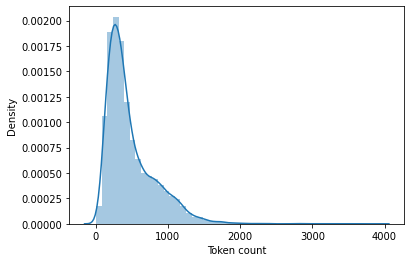

In [10]:
# Clean lyrics and display their lengths
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

for x in range(dataset.shape[0]):

    # Remove all elements between [] and clean up some more
    new_string = re.sub("\[.*?\]", "", dataset['Lyrics'][x])
    new_string = new_string.replace('\n', ' ')
    new_string = new_string.replace('[', '')
    new_string = new_string.replace(']', '')

    dataset['Lyrics'][x] = new_string

token_lens = []

# Plot token lengths
for x in range(dataset.shape[0]):

    # Max length determined by plotting
    tokens = tokenizer.encode(dataset['Lyrics'][x])
    token_lens.append(len(tokens))

print(max(token_lens))

sns.distplot(token_lens)
plt.xlabel('Token count')

In [11]:
dataset

,Name,Artist,Album,Release Date,Lyrics,Class
6475,Summer Days,Martin Garrix,Summer Days (feat. Macklemore & Patrick Stump ...,2019-07-12,I got this feeling on a summer day Knew it wh...,Dance
444,Slaves of Fear,Amon Amarth,Surtur Rising,2011-03-29,They speak of love and tolerance They thrive o...,Metal
3140,Torch,Emmure,Look at Yourself,2017-03-03,I did not pass the torch Just to be engulfed ...,Metal
361,Allah Tano,Alpha Blondy,Positive Energy,2015-05-18,La ilaha i la la Mohamadou Rassoulilaye!! La ...,Reggae & Dub
2846,Laugh Now Cry Later,Drake,Laugh Now Cry Later (feat. Lil Durk),2020-08-14,"Woah, woah Yeah Sometimes we laugh and some...",Rap
...,...,...,...,...,...,...
3284,The Gentle Art of Making Enemies,Faith No More,"King for a Day, Fool for a Lifetime (2016 Rema...",1995,The words are so familiar All the same greats...,Metal
1650,KNOW ME,BRONSON,KNOW ME (Cassian Remix),2020-09-29,"Karma used to move so fast, move so fast Now ...",Dance
486,Amo Soltanto Te,Andrea Bocelli,Sì Forever (The Diamond Edition),2019-11-08,È troppo tempo che Non siamo soli io e te Non...,Classical
5552,Agnus Dei,Katherine Jenkins,The 50 Greatest Romantic Pieces by Katherine J...,2013-04-02,"Agnus dei Qui tollis peccata mundi Miserere, m...",Classical


In [12]:
# Import BERT tokenization elements
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 512

In [13]:
# Class for data set
alphabetical = []

for el in dataset['Class']:
    if (el not in alphabetical):
        alphabetical.append(el)

alphabetical = sorted(alphabetical)

print(alphabetical)

for x in range(len(dataset['Class'])):
    for y in range(len(alphabetical)):
        if (dataset['Class'][x] == alphabetical[y]):
            dataset['Class'][x] = y

# Binarizes the mood labels
encoder = LabelBinarizer()
moods = encoder.fit_transform(dataset['Class'].tolist())

print(moods)

# Data set for BERT created here !
class LyricsDataset(Dataset):

  def __init__(self, lyrics, targets, tokenizer, max_len):

      self.lyrics     = lyrics
      self.targets    = targets
      self.tokenizer  = tokenizer
      self.max_len    = max_len

  def __len__(self):
      return len(self.lyrics)

  def __getitem__(self, item):

      lyric = str(self.lyrics[item])
      target = self.targets[item]

      encoding = self.tokenizer.encode_plus(
          lyric,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          truncation = True,
          return_attention_mask=True,
          return_tensors='pt',
      )

      return {
          'lyric_text': lyric,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
      }

['Blues', 'Classical', 'Country', 'Dance', 'Disco & Funk', 'Jazz', 'Metal', 'Pop', 'Rap', 'Reggae & Dub', 'Reggaeton', 'Rock']


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
# Split data set (80/10/10)
df_train, df_test = train_test_split(
  dataset,
  test_size=0.2,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((8000, 6), (1000, 6), (1000, 6))

In [15]:
# Prepare data for BERT

encoder = LabelBinarizer()
moods = encoder.fit_transform(dataset['Class'].tolist())

def create_data_loader(df, tokenizer, max_len, batch_size):

    ds = LyricsDataset(
        lyrics    = df.Lyrics.to_numpy(),
        targets   = encoder.fit_transform(df['Class'].tolist()),
        tokenizer = tokenizer,
        max_len   = max_len
    )

    return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
    )

BATCH_SIZE = 12

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader  = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [16]:
data = next(iter(train_data_loader))

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([12, 512])
torch.Size([12, 512])
torch.Size([12, 12])


In [17]:
# BERT from pre-trained architecture with frop-out and linear layer
class LyricClassifier(nn.Module):

    def __init__(self, n_classes):
        super(LyricClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)

        return self.out(output)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LyricClassifier(len(alphabetical))
model = model.to(device)

In [20]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([12, 512])
torch.Size([12, 512])


In [21]:
EPOCHS = 5

# Create optmizer and its schedule and loss
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [22]:
# Function for training network
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples,
    epoch
):
    model = model.train()
    losses = []
    correct_predictions = 0

    progress_bar = tqdm(data_loader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for d in progress_bar:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)

        targets_1d = torch.argmax(targets, 1)

        loss = loss_fn(outputs, targets_1d)
        correct_predictions += torch.sum(preds == targets_1d)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(d))})

    return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
# Function for evaluating network
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():

        progress_bar = tqdm(data_loader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

        for d in progress_bar:

          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )

          targets_1d = torch.argmax(targets, 1)

          _, preds = torch.max(outputs, dim=1)
          loss = loss_fn(outputs, targets_1d)
          correct_predictions += torch.sum(preds == targets_1d)
          losses.append(loss.item())

          progress_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(d))})
          
    return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
%%time

torch.cuda.empty_cache()

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train),
      epoch
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------


Train loss 1.4976937871376077 accuracy 0.51575


Val   loss 1.1274145472617376 accuracy 0.64

Epoch 2/5
----------


Train loss 0.8987673150411789 accuracy 0.71375


Val   loss 1.0226377218606926 accuracy 0.672

Epoch 3/5
----------


Train loss 0.5917680300213676 accuracy 0.81825


Val   loss 1.0442983568424271 accuracy 0.6880000000000001

Epoch 4/5
----------


Train loss 0.3800096241464054 accuracy 0.8911250000000001


Val   loss 1.1766300951795918 accuracy 0.668

Epoch 5/5
----------


Train loss 0.25233495056160027 accuracy 0.93075


Val   loss 1.182209782391077 accuracy 0.6920000000000001

CPU times: user 41min 43s, sys: 30min 57s, total: 1h 12min 41s
Wall time: 1h 13min 30s


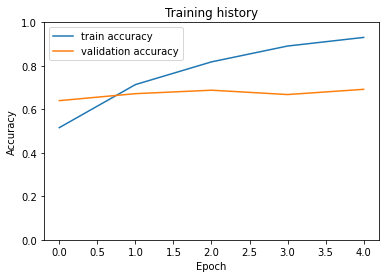

In [25]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('BERT Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [26]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()

0.7020000000000001

In [35]:
# Function to get predictions for more in-depth resulst
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["lyric_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)

            targets_1d = torch.argmax(targets, 1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets_1d)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [36]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [37]:
print(classification_report(y_test, y_pred, target_names=alphabetical))

              precision    recall  f1-score   support

       Blues       0.51      0.51      0.51        37
   Classical       0.86      0.73      0.79        41
     Country       0.69      0.59      0.64        70
       Dance       0.46      0.46      0.46        69
Disco & Funk       0.40      0.43      0.42        37
        Jazz       0.86      0.75      0.80        92
       Metal       0.87      0.85      0.86       164
         Pop       0.51      0.56      0.53       133
         Rap       0.87      0.85      0.86       118
Reggae & Dub       0.87      0.75      0.81        61
   Reggaeton       0.97      0.96      0.96        94
        Rock       0.41      0.55      0.47        84

    accuracy                           0.70      1000
   macro avg       0.69      0.67      0.68      1000
weighted avg       0.72      0.70      0.71      1000



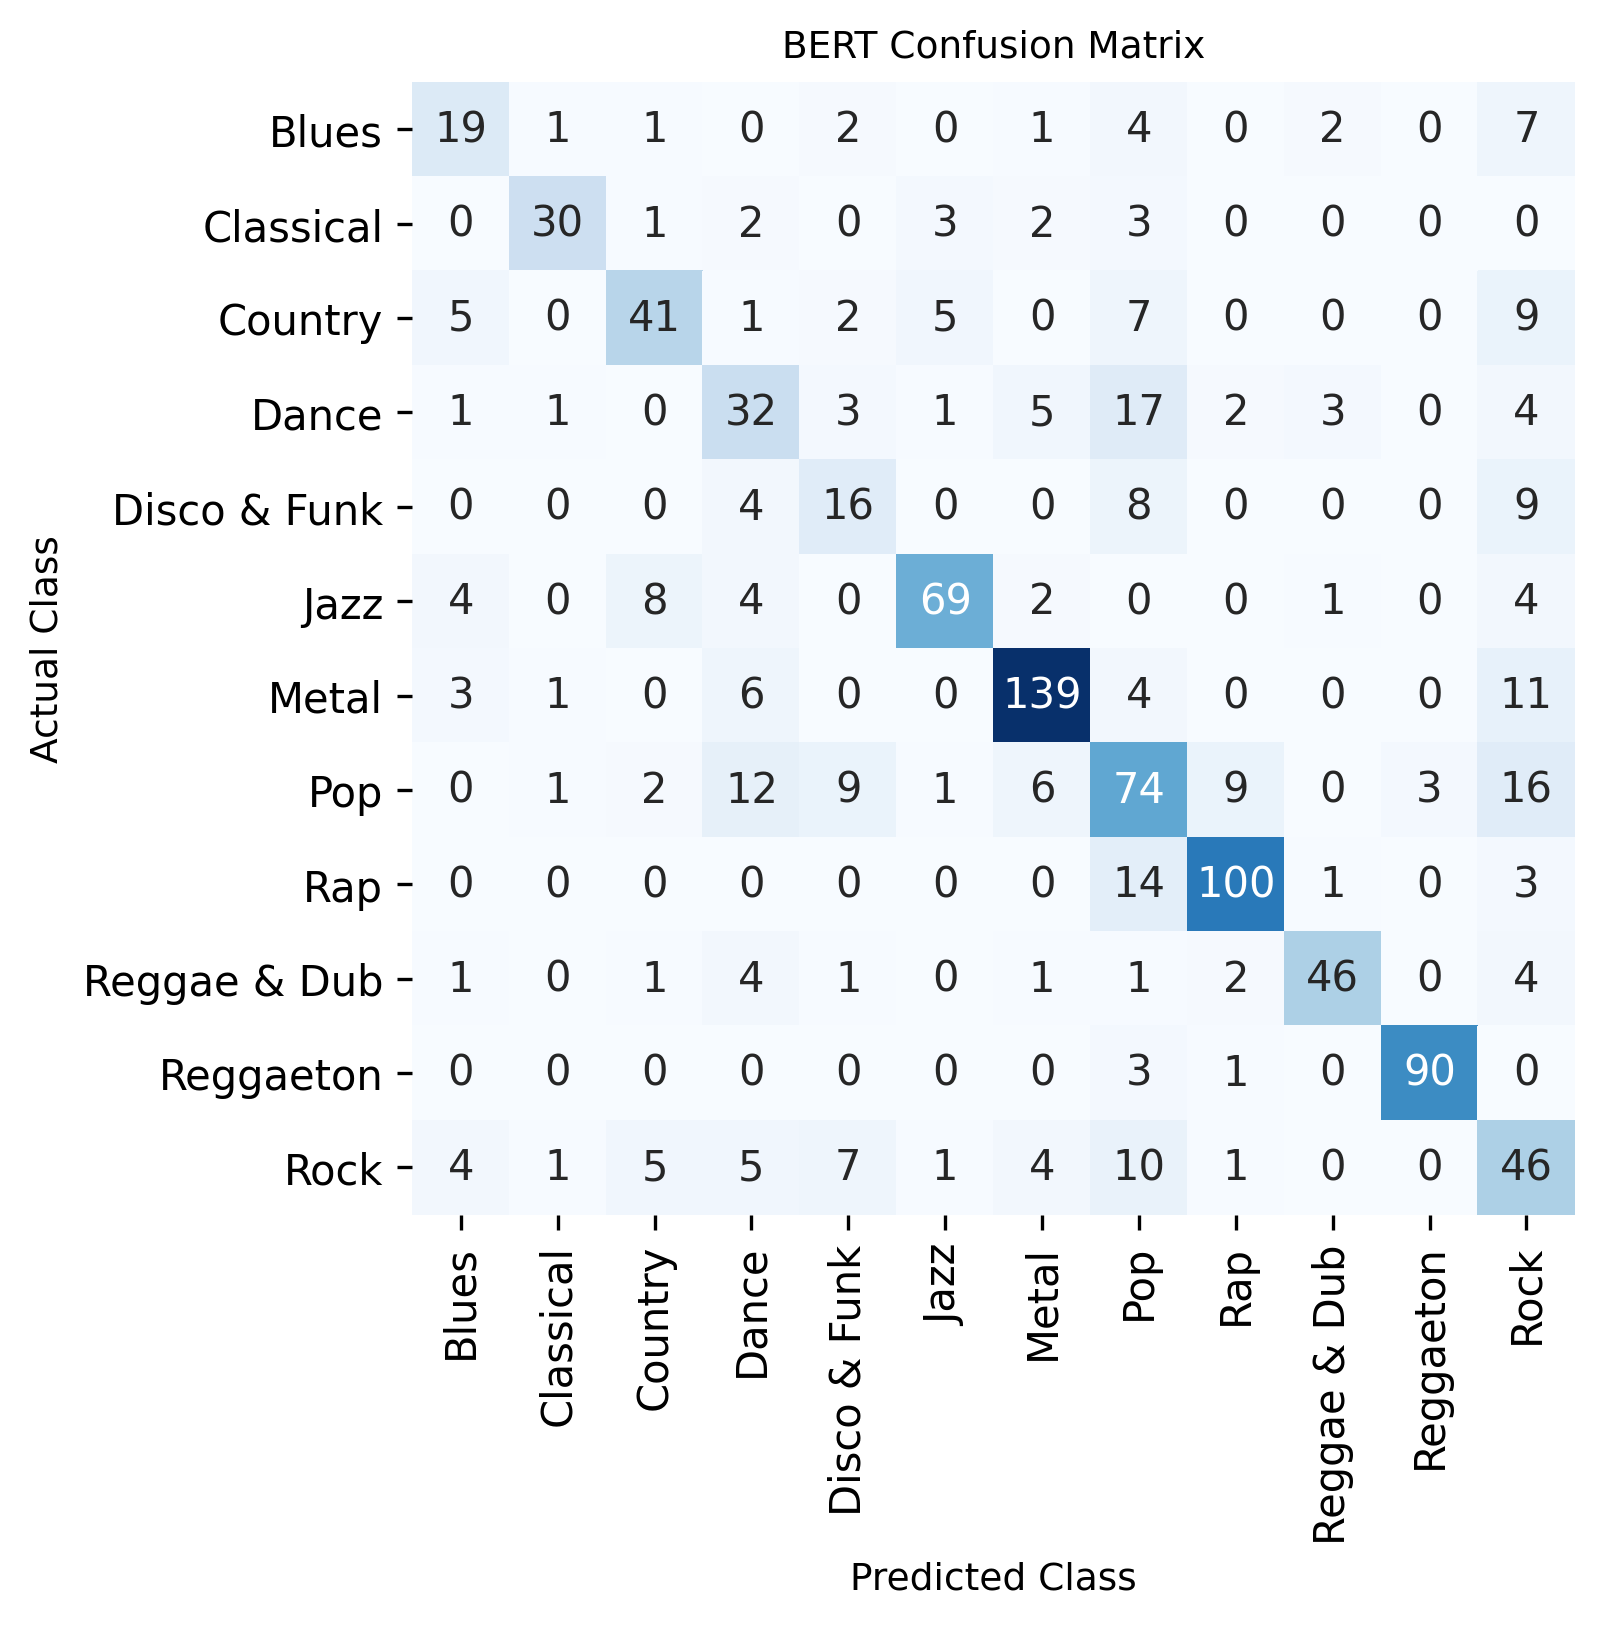

In [47]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)

# Formats and displays the confusion matrix
figure(num=None, figsize=(5, 5), dpi=300)
df_cm = pd.DataFrame(cm, index=alphabetical, columns=alphabetical)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues, fmt='g', cbar=False)
plt.title('BERT Confusion Matrix', fontsize=9)
plt.xlabel("Predicted Class", fontsize=9)
plt.ylabel("Actual Class", fontsize=9)
plt.show()